In [ ]:
from __future__ import print_function
import os
import argparse
import torch, gc
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
%pip install import-ipynb

In [ ]:
import import_ipynb

from resnet import *
from vgg import *
from d_trades import *

In [ ]:
parser = argparse.ArgumentParser(description='PyTorch CIFAR TRADES Adversarial Training')
parser.add_argument('--batch-size', type=int, default=128, metavar='N',
                    help='input batch size for training (default: 128)')
parser.add_argument('--test-batch-size', type=int, default=128, metavar='N',
                    help='input batch size for testing (default: 128)')
parser.add_argument('--epochs', type=int, default=5, metavar='N',
                    help='number of epochs to train')
parser.add_argument('--weight-decay', '--wd', default=2e-4,
                    type=float, metavar='W')
parser.add_argument('--lr', type=float, default=0.1, metavar='LR',
                    help='learning rate')
parser.add_argument('--momentum', type=float, default=0.9, metavar='M',
                    help='SGD momentum')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--epsilon', default=0.031,
                    help='perturbation')
parser.add_argument('--num-steps', default=10,
                    help='perturb number of steps')
parser.add_argument('--step-size', default=0.007,
                    help='perturb step size')
parser.add_argument('--alpha', default=1.0,
                    help='regularization, i.e., 1/lambda in TRADES')
parser.add_argument('--beta', default=1.0,
                    help='regularization, i.e., 1/lambda in TRADES')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=100, metavar='N',
                    help='how many batches to wait before logging training status')
parser.add_argument('--model-dir', default='./model-cifar-wideResNet',
                    help='directory of model for saving checkpoint')
parser.add_argument('--save-freq', '-s', default=1, type=int, metavar='N',
                    help='save frequency')

args, unknown = parser.parse_known_args()

In [ ]:
# settings
#model_dir = args.model_dir
#if not os.path.exists(model_dir):
#    os.makedirs(model_dir)
use_cuda = not args.no_cuda and torch.cuda.is_available()
torch.manual_seed(args.seed)
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [ ]:
'''
# setup data loader
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
])
trainset = torchvision.datasets.CIFAR10(root='../data', train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=args.batch_size, shuffle=True, **kwargs)
testset = torchvision.datasets.CIFAR10(root='../data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(testset, batch_size=args.test_batch_size, shuffle=False, **kwargs)
'''

"\n# setup data loader\ntransform_train = transforms.Compose([\n    transforms.RandomCrop(32, padding=4),\n    transforms.RandomHorizontalFlip(),\n    transforms.ToTensor(),\n])\ntransform_test = transforms.Compose([\n    transforms.ToTensor(),\n])\ntrainset = torchvision.datasets.CIFAR10(root='../data', train=True, download=True, transform=transform_train)\ntrain_loader = torch.utils.data.DataLoader(trainset, batch_size=args.batch_size, shuffle=True, **kwargs)\ntestset = torchvision.datasets.CIFAR10(root='../data', train=False, download=True, transform=transform_test)\ntest_loader = torch.utils.data.DataLoader(testset, batch_size=args.test_batch_size, shuffle=False, **kwargs)\n"

In [ ]:
transform = transforms.ToTensor()
train_dataset = datasets.CIFAR10('../data', train=True, download=True, transform=transform)

In [ ]:
k_folds = 2
kfold = KFold(n_splits=k_folds, shuffle=True)

In [ ]:
lambda_min = []
lambda_max = []
lambda_mean = []
def train(args, model, device, train_loader, optimizer, epoch, fold):
    model.train()
    #print(args)
    #print(model)
    #print(optimizer)
    #print(epoch)
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()

        # calculate robust loss
        loss, lambda_value = d_trades_loss(model=model,
                           x_natural=data,
                           y=target,
                           optimizer=optimizer,
                           step_size=args.step_size,
                           epsilon=args.epsilon,
                           perturb_steps=args.num_steps,
                           alpha=args.alpha,
                           beta=args.beta,
                        )
        loss.backward()
        optimizer.step()

        # print progress
        if batch_idx % args.log_interval == 0:
            #print(data)
            #print(target)
            #print(batch_idx)
            #print(data.shape)
            #print(target.shape)
            lambda_min.append(lambda_value.min().item())
            lambda_max.append(lambda_value.max().item())
            lambda_mean.append(lambda_value.mean().item())
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} \tLambda Mean: {:.2f} \tLambda Min: {:.2f} \tLambda Max: {:.2f}'.format(
                                            epoch,
                                            batch_idx * len(data),
                                            len(train_loader.dataset),
                                            100. * batch_idx / len(train_loader),
                                            loss.item(),
                                            lambda_value.mean().item(),
                                            lambda_value.min().item(),
                                            lambda_value.max().item()))

In [ ]:
def _pgd_whitebox(model,
                  X,
                  y,
                  epsilon=args.epsilon,
                  num_steps=20,
                  step_size=0.003):
    out = model(X)
    err = (out.data.max(1)[1] != y.data).float().sum()
    X_pgd = Variable(X.data, requires_grad=True)

    random_noise = torch.FloatTensor(*X_pgd.shape).uniform_(-epsilon, epsilon).to(device)
    X_pgd = Variable(X_pgd.data + random_noise, requires_grad=True)

    for _ in range(num_steps):
        opt = optim.SGD([X_pgd], lr=1e-3)
        opt.zero_grad()

        with torch.enable_grad():
            loss = nn.CrossEntropyLoss()(model(X_pgd), y)
        loss.backward()
        eta = step_size * X_pgd.grad.data.sign()
        X_pgd = Variable(X_pgd.data + eta, requires_grad=True)
        eta = torch.clamp(X_pgd.data - X.data, -epsilon, epsilon)
        X_pgd = Variable(X.data + eta, requires_grad=True)
        X_pgd = Variable(torch.clamp(X_pgd, 0, 1.0), requires_grad=True)
    err_pgd = (model(X_pgd).data.max(1)[1] != y.data).float().sum()
    return err, err_pgd

In [ ]:
def eval_adv_test_whitebox(model, device, test_loader):

    model.eval()
    robust_err_total = 0
    natural_err_total = 0

    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        # pgd attack
        X, y = Variable(data, requires_grad=True), Variable(target)
        err_natural, err_robust = _pgd_whitebox(model, X, y)
        robust_err_total += err_robust
        natural_err_total += err_natural
    print('natural_acc: ', 1 - natural_err_total / len(test_loader.dataset))
    print('robust_acc: ', 1- robust_err_total / len(test_loader.dataset))
    return 1 - natural_err_total / len(test_loader.dataset), 1- robust_err_total / len(test_loader.dataset)


In [ ]:
def adjust_learning_rate(optimizer, epoch):
    """decrease the learning rate"""
    lr = args.lr
    if epoch >= 75:
        lr = args.lr * 0.1
    if epoch >= 90:
        lr = args.lr * 0.01
    if epoch >= 100:
        lr = args.lr * 0.001
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
def main():
    natural_pgd_acc = []
    robust_pgd_acc = []
    #robust_attack_acc_fold = []
    #robust_attack2_acc_fold = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(train_dataset)):
        print(f'Fold {fold+1}')

        train_subset = Subset(train_dataset, train_idx)
        val_subset = Subset(train_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=args.batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=args.batch_size, shuffle=False)

        # model = ResNet18()
        model = vgg16()

        model = model.to(device)
        optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

        for epoch in range(1, args.epochs + 1):
            # adjust learning rate for SGD
            adjust_learning_rate(optimizer, epoch)

            # adversarial training
            train(args, model, device, train_loader, optimizer, epoch, fold)

        print('================================================================')
        natural_acc_pgd,robust_acc_pgd = eval_adv_test_whitebox(model, device, val_loader) #PGD20

        print('================================================================')

        natural_pgd_acc.append(natural_acc_pgd) #Precision natural PGD20
        robust_pgd_acc.append(robust_acc_pgd) #Precision Robustez PGD20
        #Precision FGSM o AutoAttack
        #Precision ataque caja negra

        # save checkpoint
        #if epoch % args.save_freq == 0:
        #    torch.save(model.state_dict(),
        #               os.path.join(model_dir, 'model-nn-epoch{}.pt'.format(epoch)))
        #    torch.save(optimizer.state_dict(),
        #               os.path.join(model_dir, 'opt-nn-checkpoint_epoch{}.tar'.format(epoch)))

if __name__ == '__main__':
    main()

Fold 1
Train Epoch: 1 [0/25000 (0%)]	Loss: 2.350633 	Lambda Mean: 1.15 	Lambda Min: 0.85 	Lambda Max: 1.96
Train Epoch: 1 [12800/25000 (51%)]	Loss: 2.019148 	Lambda Mean: 0.89 	Lambda Min: 0.25 	Lambda Max: 1.61
Train Epoch: 2 [0/25000 (0%)]	Loss: 1.722919 	Lambda Mean: 0.64 	Lambda Min: 0.06 	Lambda Max: 1.27
Train Epoch: 2 [12800/25000 (51%)]	Loss: 1.715619 	Lambda Mean: 0.90 	Lambda Min: 0.15 	Lambda Max: 1.66
Train Epoch: 3 [0/25000 (0%)]	Loss: 1.575934 	Lambda Mean: 0.77 	Lambda Min: 0.12 	Lambda Max: 1.75
Train Epoch: 3 [12800/25000 (51%)]	Loss: 1.568775 	Lambda Mean: 0.87 	Lambda Min: 0.09 	Lambda Max: 1.74
Train Epoch: 4 [0/25000 (0%)]	Loss: 1.517365 	Lambda Mean: 0.80 	Lambda Min: 0.27 	Lambda Max: 1.71
Train Epoch: 4 [12800/25000 (51%)]	Loss: 1.309140 	Lambda Mean: 0.85 	Lambda Min: 0.17 	Lambda Max: 1.58
Train Epoch: 5 [0/25000 (0%)]	Loss: 1.259982 	Lambda Mean: 0.82 	Lambda Min: 0.06 	Lambda Max: 1.50
Train Epoch: 5 [12800/25000 (51%)]	Loss: 1.336716 	Lambda Mean: 0.70 	Lam

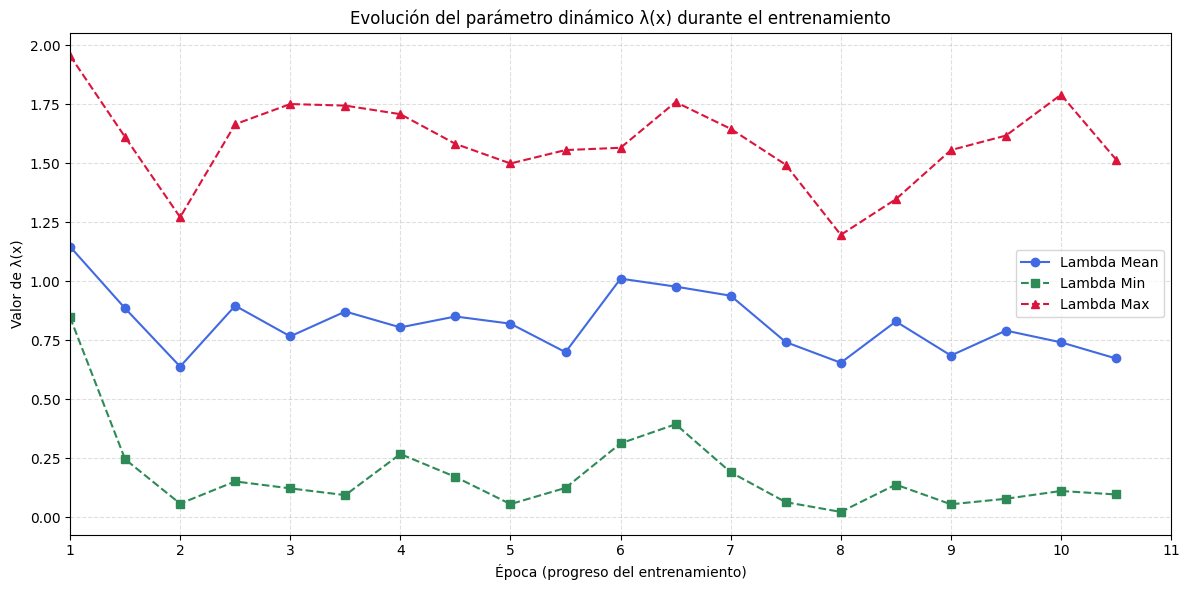

In [ ]:
epoch_array = [1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,5.5,6.0,6.5,7.0,7.5,8.0,8.5,9.0,9.5,10,10.5]

epoch_np = np.array(epoch_array)
max_epoch = int(np.ceil(epoch_np.max()))

plt.figure(figsize=(12, 6))
plt.plot(epoch_array, lambda_mean, label='Lambda Mean', color='royalblue', marker='o')
plt.plot(epoch_array, lambda_min,  label='Lambda Min',  color='seagreen', linestyle='--', marker='s')
plt.plot(epoch_array, lambda_max,  label='Lambda Max',  color='crimson', linestyle='--', marker='^')

# Rango del eje X y ticks coherentes con tus datos
plt.xlim(1, max_epoch)
plt.xticks(np.arange(1, max_epoch + 1, 1))

# Formato del gráfico
plt.title("Evolución del parámetro dinámico λ(x) durante el entrenamiento")
plt.xlabel("Época (progreso del entrenamiento)")
plt.ylabel("Valor de λ(x)")
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()

# Mostrar gráfico
plt.show()

In [ ]:
print(len(epoch_array))

19


In [ ]:
'''
def main():
    # init model, ResNet18() can be also used here for training
    model = ResNet18().to(device)
    #model = vgg16().to(device)
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=args.weight_decay)

    for epoch in range(1, args.epochs + 1):
        # adjust learning rate for SGD
        adjust_learning_rate(optimizer, epoch)

        # adversarial training
        train(args, model, device, train_loader, optimizer, epoch)

        # evaluation on natural examples
        print('================================================================')
        #eval_train(model, device, train_loader)
        #eval_test(model, device, test_loader)
        print('================================================================')

        # save checkpoint
        #if epoch % args.save_freq == 0:
        #    torch.save(model.state_dict(),
        #               os.path.join(model_dir, 'model-wideres-epoch{}.pt'.format(epoch)))
        #    torch.save(optimizer.state_dict(),
        #               os.path.join(model_dir, 'opt-wideres-checkpoint_epoch{}.tar'.format(epoch)))


if __name__ == '__main__':
    main()
'''